# Convolutional neural networks for artistic content combine

This iPython notebook is an implementation of a popular paper ([Gatys et al., 2015](https://arxiv.org/abs/1508.06576)) that demonstrates how to use neural networks to transfer artistic style from one image onto another. It is meant to go along with a [related blog post](https://harishnarayanan.org/writing/artistic-style-transfer/) that provides more context, and explains a lot of the theory behind the steps that follow.

There will be a companion blog post and project coming soon in the future that implements a much faster version of this algorithm ([Johnson et al., 2016](https://arxiv.org/abs/1603.08155)) and wraps it in a webapp, a la [Prisma](https://prisma-ai.com).

In [1]:
from __future__ import print_function

import os.path
import time
from PIL import Image
import numpy as np

from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16

from scipy.misc import imsave

Using TensorFlow backend.


## Load and preprocess the content and style images

Our first task is to load the content and style images. Note that the content image we're working with is not particularly high quality, but the output we'll arrive at the end of this process still looks really good.

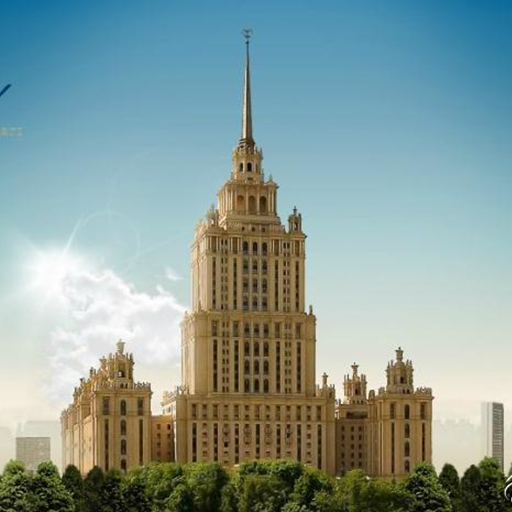

In [2]:
height = 512
width = 512

content_image_path = r'..\..\images\ukhotel1.jpg'
content_image = Image.open(content_image_path)
content_image = content_image.resize((height, width))
content_image

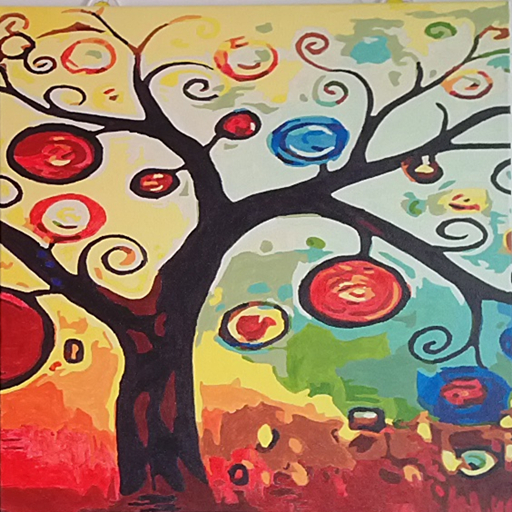

In [3]:
style_image_path = r'..\..\images\styles\moneytree2.jpg'
style_image = Image.open(style_image_path)
style_image = style_image.resize((height, width))
style_image

Then, we convert these images into a form suitable for numerical processing. In particular, we add another dimension (beyond the classic height x width x 3 dimensions) so that we can later concatenate the representations of these two images into a common data structure.

In [4]:
def reshape_img(x) :
    print(backend.image_data_format(), "Shape before", x.shape)
    if backend.image_data_format() == 'channels_first':
        x = x.reshape(x.shape[2], x.shape[0], x.shape[1])
    else:
        x = x.reshape(x.shape[0], x.shape[1], x.shape[2])
    print(backend.image_data_format(), "Shape after", x.shape)
    return x

In [5]:
content_array = np.asarray(content_image, dtype='float32')
content_array = reshape_img(content_array)
content_array = np.expand_dims(content_array, axis=0)
print(content_array.shape)

style_array = np.asarray(style_image, dtype='float32')
style_array = reshape_img(style_array)
style_array = np.expand_dims(style_array, axis=0)
print(style_array.shape)

channels_last Shape before (512, 512, 3)
channels_last Shape after (512, 512, 3)
(1, 512, 512, 3)
channels_last Shape before (512, 512, 3)
channels_last Shape after (512, 512, 3)
(1, 512, 512, 3)


Before we proceed much further, we need to massage this input data to match what was done in [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), the paper that introduces the *VGG Network* model that we're going to use shortly.

For this, we need to perform two transformations:

1. Subtract the mean RGB value (computed previously on the [ImageNet training set](http://image-net.org) and easily obtainable from Google searches) from each pixel.
2. Flip the ordering of the multi-dimensional array from *RGB* to *BGR* (the ordering used in the paper).

In [6]:
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

combination_array = np.random.uniform(0, 255, (1, height, width, 3)) - 128.

Now we're ready to use these arrays to define variables in Keras' backend (the TensorFlow graph). We also introduce a placeholder variable to store the *combination* image that retains the content of the content image while incorporating the style of the style image.

In [7]:
combination_image = backend.placeholder((1, height, width, 3))
# combination_image = backend.placeholder((1, 3, height, width))
content_array.shape, style_array.shape, combination_image.shape, height, width

((1, 512, 512, 3),
 (1, 512, 512, 3),
 TensorShape([Dimension(1), Dimension(512), Dimension(512), Dimension(3)]),
 512,
 512)

Finally, we concatenate all this image data into a single tensor that's suitable for processing by Keras' VGG16 model.

## Reuse a model pre-trained for image classification to define loss functions

The core idea introduced by [Gatys et al. (2015)](https://arxiv.org/abs/1508.06576) is that convolutional neural networks (CNNs) pre-trained for image classification already know how to encode perceptual and semantic information about images. We're going to follow their idea, and use the *feature spaces* provided by one such model to independently work with content and style of images.

The original paper uses the 19 layer VGG network model from [Simonyan and Zisserman (2015)](https://arxiv.org/abs/1409.1556), but we're going to instead follow [Johnson et al. (2016)](https://arxiv.org/abs/1603.08155) and use the 16 layer model (VGG16). There is no noticeable qualitative difference in making this choice, and we gain a tiny bit in speed.

Also, since we're not interested in the classification problem, we don't need the fully connected layers or the final softmax classifier. We only need the part of the model marked in green in the table below.

![VGG Network Architectures](models\vgg-architecture.png "VGG Network Architectures")

It is trivial for us to get access to this truncated model because Keras comes with a set of pretrained models, including the VGG16 model we're interested in. Note that by setting `include_top=False` in the code below, we don't include any of the fully connected layers.

As is clear from the table above, the model we're working with has a lot of layers. Keras has its own names for these layers. Let's make a list of these names so that we can easily refer to individual layers later.

In [9]:
model = VGG16(input_tensor=combination_image, weights='imagenet', include_top=False)
layers = dict([(layer.name, layer.output) for layer in model.layers])
layers
# layer_dict = dict([(layer.name, layer) for layer in model.layers])
# layer_dict

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(1, 512, 512, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(1, 512, 512, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(1, 256, 256, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(1, 256, 256, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(1, 256, 256, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(1, 128, 128, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(1, 128, 128, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(1, 128, 128, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(1, 128, 128, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(1, 64, 64, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(1, 64, 64, 512) dtype=float32>,
 'b

If you stare at the list above, you'll convince yourself that we covered all items we wanted in the table (the cells marked in green). Notice also that because we provided Keras with a concrete input tensor, the various TensorFlow tensors get well-defined shapes.

---

The crux of the paper we're trying to reproduce is that the [style transfer problem can be posed as an optimisation problem](https://harishnarayanan.org/writing/artistic-style-transfer/), where the loss function we want to minimise can be decomposed into three distinct parts: the *content loss*, the *style loss* and the *total variation loss*.

The relative importance of these terms are determined by a set of scalar weights. These are  arbitrary, but the following set have been chosen after quite a bit of experimentation to find a set that generates output that's aesthetically pleasing to me.

We'll now use the feature spaces provided by specific layers of our model to define these three loss functions. We begin by initialising the total loss to 0 and adding to it in stages.

### The content loss

For the content loss, we follow Johnson et al. (2016) and draw the content feature from `block2_conv2`, because the original choice in Gatys et al. (2015) (`block4_conv2`) loses too much structural detail. And at least for faces, I find it more aesthetically pleasing to closely retain the structure of the original content image.

This variation across layers is shown for a couple of examples in the images below (just mentally replace `reluX_Y` with our Keras notation `blockX_convY`).

![Content feature reconstruction](models\content-feature.png "Content feature reconstruction")

The content loss is the (scaled, squared) Euclidean distance between feature representations of the content and combination images.

In [10]:
def MSE(y, y_hat) :
    return backend.mean(backend.square(y-y_hat))

In [11]:
def get_content_loss(model, layer_names, img_array) :
    content_losses = backend.variable(0.)
    model_input = model.input
    img_content = img_combined = 0
    for layer_name in layer_names :
        layer_output = model.get_layer(layer_name).output
        get_layer_output = backend.function([model.input], [layer_output])
        img_content = get_layer_output([img_array])[0]
        img_combined = layer_output
#         print(img_content, img_combined)
        content_losses += MSE(img_content, img_combined)
    content_loss = content_losses / len(layer_names)
#     print(type(content_loss), len(layer_names))
    return content_loss

### The style loss

This is where things start to get a bit intricate.

For the style loss, we first define something called a *Gram matrix*. The terms of this matrix are proportional to the covariances of corresponding sets of features, and thus captures information about which features tend to activate together. By only capturing these aggregate statistics across the image, they are blind to the specific arrangement of objects inside the image. This is what allows them to capture information about style independent of content. (This is not trivial at all, and I refer you to [a paper that attempts to explain the idea](https://arxiv.org/abs/1606.01286).)

The Gram matrix can be computed efficiently by reshaping the feature spaces suitably and taking an outer product.


In [12]:
def gram_matrix(x):  
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

The style loss is then the (scaled, squared) Frobenius norm of the difference between the Gram matrices of the style and combination images.

Again, in the following code, I've chosen to go with the style features from layers defined in Johnson et al. (2016) rather than Gatys et al. (2015) because I find the end results more aesthetically pleasing. I encourage you to experiment with these choices to see varying results.

In [13]:
def calc_style_loss(y, y_hat) :
    channels = 3
    size = height * width
    return backend.sum(backend.square(y - y_hat)) / (4. * (channels ** 2) * (size ** 2))

In [14]:
def get_style_loss(model, layer_names, img_array) :
    style_losses = backend.variable(0.)
    for layer_name in layer_names :
        layer_output = model.get_layer(layer_name).output
        get_layer_output = backend.function([model.input], [layer_output])
        img_style = get_layer_output([img_array])[0]
        img_combined = layer_output
#         print(img_style, img_combined)
        gram_img_style = gram_matrix(img_style[0, :, :, :])
        gram_img_combined = gram_matrix(img_combined[0, :, :, :])
        style_losses += (calc_style_loss(gram_img_style, gram_img_combined))
    style_loss = style_losses / len(layer_names)
#     print(type(style_loss), len(layer_names))
    return style_loss

### The total variation loss

Now we're back on simpler ground.

If you were to solve the optimisation problem with only the two loss terms we've introduced so far (style and content), you'll find that the output is quite noisy. We thus add another term, called the [total variation loss](http://arxiv.org/abs/1412.0035) (a regularisation term) that encourages spatial smoothness.

You can experiment with reducing the `total_variation_weight` and play with the noise-level of the generated image.

In [15]:
def get_denoise_loss(x):
    a = backend.square(x[:, :height-1, :width-1, :] - x[:, 1:, :width-1, :])
    b = backend.square(x[:, :height-1, :width-1, :] - x[:, :height-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

## Define needed gradients and solve the optimisation problem

[The goal of this journey](https://harishnarayanan.org/writing/artistic-style-transfer/) was to setup an optimisation problem that aims to solve for a *combination image* that contains the content of the content image, while having the style of the style image. Now that we have our input images massaged and our loss function calculators in place, all we have left to do is define gradients of the total loss relative to the combination image, and use these gradients to iteratively improve upon our combination image to minimise the loss.

We start by defining the gradients.

In [16]:
weight_content0 = 8
weight_content1 = 2
weight_style = 10.0
weight_denoise = 0.3

content_layer_names = ['block4_conv1']
style_layer_names = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3', 'block5_conv3']

loss = backend.variable(0.)

# the problem is, when solve loss_content alone, it's ok to rebuild the original image
# however, when 3 losses together, only the style rebuild


In [17]:
loss_content0 = get_content_loss(model, content_layer_names, content_array)
loss_content1 = get_content_loss(model, content_layer_names, style_array)
# loss_style = get_style_loss(model, style_layer_names, style_array)
# loss_denoise = get_denoise_loss(combination_image)
# loss = weight_content*loss_content + weight_content1*loss_content1 + weight_denoise*loss_denoise

loss = weight_content0*loss_content0 + weight_content1*loss_content1 

grad = backend.gradients(loss, combination_image)[0]
optimize_image = backend.function([combination_image], [loss_content0, loss_content1, loss, grad])

<class 'tensorflow.python.framework.ops.Tensor'> 1
<class 'tensorflow.python.framework.ops.Tensor'> 1


Now we're finally ready to solve our optimisation problem. This combination image begins its life as a random collection of (valid) pixels, and we use the [L-BFGS](https://en.wikipedia.org/wiki/Limited-memory_BFGS) algorithm (a quasi-Newton algorithm that's significantly quicker to converge than standard gradient descent) to iteratively improve upon it.

We stop after 10 iterations because the output looks good to me and the loss stops reducing significantly.

In [18]:
x = np.random.uniform(0, 255, (1, height, width, 3)) - 128.
# x = content_array
w = np.concatenate((content_array, style_array, x))
print(x.shape, content_array.shape, style_array.shape, w.shape)

(1, 512, 512, 3) (1, 512, 512, 3) (1, 512, 512, 3) (3, 512, 512, 3)


In [19]:
step_size = 10
num_iterations = 100
loss_content0 = 0.0
loss_content1 = 0.0

for i in range(num_iterations) :
    start_time = time.time()
    loss_content0, loss_content1, loss, grad = optimize_image([x])
    step_size_scaled = step_size / (np.std(grad) + 1e-8)
    x -= grad*step_size_scaled
    x = np.clip(x, 0.0, 255.0)
    print('Loss_content0 %f, Loss_content1 %f, Loss %f' % (loss_content0, loss_content1, loss))
    end_time = time.time()
    print('Iteration %02d completed in %ds' % (i, end_time - start_time))

Loss_content0 164465.250000, Loss_content1 277513.937500, Loss 1870749.875000
Iteration 00 completed in 1s
Loss_content0 73952.375000, Loss_content1 211150.328125, Loss 1013919.625000
Iteration 01 completed in 0s
Loss_content0 62081.332031, Loss_content1 205388.500000, Loss 907427.625000
Iteration 02 completed in 0s
Loss_content0 55663.906250, Loss_content1 207222.921875, Loss 859757.125000
Iteration 03 completed in 0s
Loss_content0 53993.457031, Loss_content1 201337.359375, Loss 834622.375000
Iteration 04 completed in 0s
Loss_content0 47811.000000, Loss_content1 207284.031250, Loss 797056.062500
Iteration 05 completed in 0s
Loss_content0 49587.933594, Loss_content1 198831.765625, Loss 794367.000000
Iteration 06 completed in 0s
Loss_content0 44389.195312, Loss_content1 204939.296875, Loss 764992.125000
Iteration 07 completed in 0s
Loss_content0 46813.957031, Loss_content1 196853.765625, Loss 768219.187500
Iteration 08 completed in 0s
Loss_content0 42164.835938, Loss_content1 203857.687

Loss_content0 36447.171875, Loss_content1 190742.312500, Loss 673062.000000
Iteration 78 completed in 0s
Loss_content0 34346.128906, Loss_content1 194631.890625, Loss 664032.812500
Iteration 79 completed in 0s
Loss_content0 36690.269531, Loss_content1 191769.906250, Loss 677062.000000
Iteration 80 completed in 0s
Loss_content0 34769.460938, Loss_content1 194638.234375, Loss 667432.125000
Iteration 81 completed in 0s
Loss_content0 36626.960938, Loss_content1 190146.515625, Loss 673308.750000
Iteration 82 completed in 0s
Loss_content0 34208.500000, Loss_content1 195089.515625, Loss 663847.000000
Iteration 83 completed in 0s
Loss_content0 36527.250000, Loss_content1 191009.734375, Loss 674237.500000
Iteration 84 completed in 0s
Loss_content0 34814.320312, Loss_content1 193887.125000, Loss 666288.812500
Iteration 85 completed in 0s
Loss_content0 35844.089844, Loss_content1 192049.578125, Loss 670851.875000
Iteration 86 completed in 0s
Loss_content0 35300.566406, Loss_content1 192700.156250

This took a while on my piddly laptop (that isn't GPU-accelerated), but here is the beautiful output from the last iteration! (Notice that we need to subject our output image to the inverse of the transformation we did to our input images before it makes sense.)

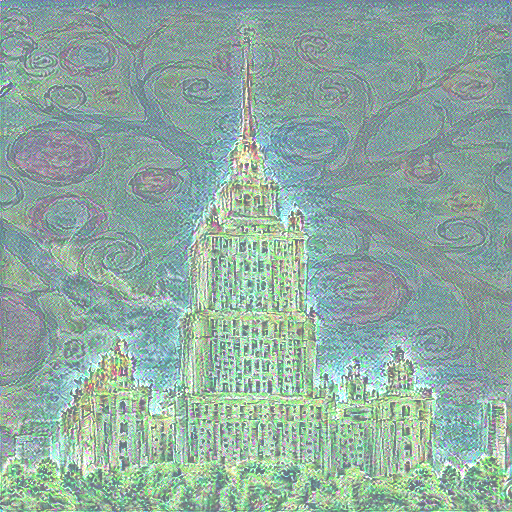

In [20]:
x = x.reshape((height, width, 3))
x = x[:, :, ::-1]
x[:, :, 0] += 103.939
x[:, :, 1] += 116.779
x[:, :, 2] += 123.68
x = np.clip(x, 0, 255).astype('uint8')

Image.fromarray(x)

In [21]:
file_name1 = os.path.basename(content_image_path)
file_name2 = os.path.basename(style_image_path)
combination_image_name = "content_" + file_name1.split(".")[0] + "_" + file_name2.split(".")[0] + ".jpg"
combination_image_path = os.path.join(r"..\..\images\outputs", combination_image_name)
imsave(combination_image_path, x)
print("Saved at: ", combination_image_path)

Saved at:  ..\..\images\outputs\ukhotel1_moneytree2.jpg


## Conclusion and further improvements

It's now your turn to play! Try changing the input images, their sizes, the weights of the different loss functions, the features used to construct them and enjoy different sorts of output. If you end up creating something you truly wish to share, [please do so](https://twitter.com/copingbear)!

As beautiful as the output of this code can be, the process we use to generate it is quite slow. And no matter how much you speed this algorithm up (with GPUs and creative hacks), it is still going to be a relatively expensive problem to solve. This is because we're solving an entire optimisation problem each time we want to generate an image.

In an upcoming article (and corresponding iPython notebook), we're going to replace this the optimisation problem with an image transformation CNN, which in turn uses the VGG16 network as before to measure losses. When this transformation network is trained on many images given a fixed style image, we end up with a fully feed-forward CNN that we can apply for style transfer. This gives us a 1000x speed up over this implementation, making it suitable for a the *Stylist* webapp.

But more on that later.